In [1]:
!nvidia-smi

Sun Jul  7 08:41:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [0]:
BATCH_SIZE = 96

In [0]:
class RandomErasing(object):
    def __init__(self, p=0.5, sl=0.02, sh=0.4, r1=0.3, r2=3):
        self.p = p
        self.sl = sl
        self.sh = sh
        self.r1 = r1
        self.r2 = r2

    def __call__(self, img):
        
        if np.random.rand() > self.p:
            return img
        
        img = np.array(img)
        
        while True:
            img_h, img_w, img_c = img.shape

            img_area = img_h * img_w
            mask_area = np.random.uniform(self.sl, self.sh) * img_area
            mask_aspect_ratio = np.random.uniform(self.r1, self.r2)
            mask_w = int(np.sqrt(mask_area / mask_aspect_ratio))
            mask_h = int(np.sqrt(mask_area * mask_aspect_ratio))
            
            mask = np.random.rand(mask_h, mask_w, img_c) * 255

            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            right = left + mask_w
            bottom = top + mask_h
        
            if right <= img_w and bottom <= img_h:
                break
        
        img[top:bottom, left:right, :] = mask
        
        return Image.fromarray(img)
        

In [6]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     RandomErasing(p=0.5, sh=0.3),
     transforms.ToTensor()]
)

test_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor()]
)

trainval_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_size = int(len(trainval_dataset) * 0.8)
val_size = len(trainval_dataset)- train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

print("train data num:", len(train_dataset))
print("val    data num:", len(val_dataset))
print("test data num:", len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader    = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
train data num: 40000
val    data num: 10000
test data num: 10000


In [0]:
def count_dataset(dataset, n_classes, normalize=False):
    counter = [0] * n_classes
    for _, label in dataset:
        counter[label] += 1
     
    if normalize:
        sum_cnt = sum(counter)
        normalized_counter = [c / sum_cnt for c in counter]
        return normalized_counter
    else:
        return counter
    
def show_bar(val, labels, title=''):
    left = [i for i in range(len(labels))]
    plt.title(title)
    plt.bar(left, val, tick_label=labels, align="center")
    plt.show()

In [0]:
train_cnt = count_dataset(train_dataset, len(classes), normalize=False)
val_cnt = count_dataset(val_dataset, len(classes), normalize=False)
test_cnt = count_dataset(test_dataset, len(classes), normalize=False)

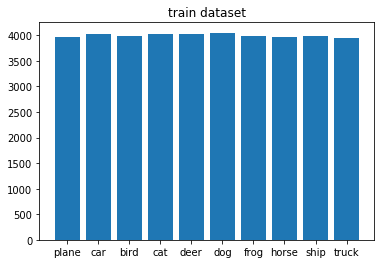

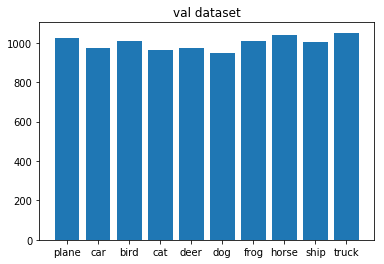

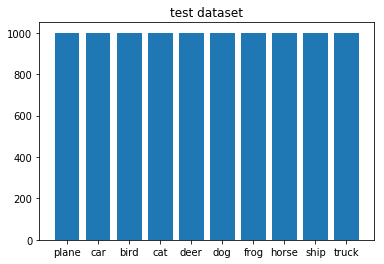

In [9]:
show_bar(train_cnt, classes, title='train dataset')
show_bar(val_cnt, classes, title='val dataset')
show_bar(test_cnt, classes, title='test dataset')

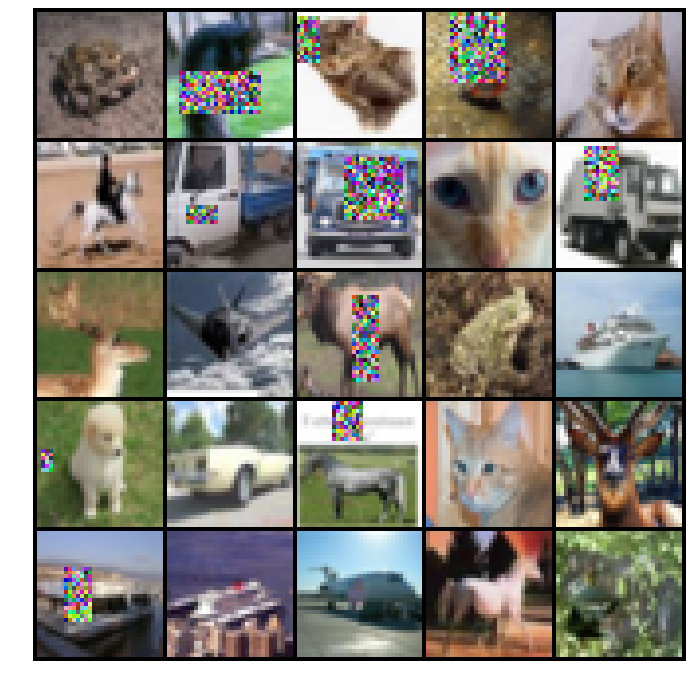

[['frog' 'bird' 'cat' 'bird' 'cat']
 ['horse' 'truck' 'truck' 'cat' 'truck']
 ['deer' 'plane' 'deer' 'frog' 'ship']
 ['dog' 'car' 'horse' 'cat' 'deer']
 ['ship' 'ship' 'plane' 'horse' 'frog']]


In [10]:
def show_img(img, figsize=(5,5)):
    plt.figure(figsize=figsize)
    if hasattr(img, 'numpy'):
        img = img.numpy()
    img = img.transpose((1, 2, 0)) # C H W -> H W C
    img = np.squeeze(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
dataiter = iter(train_loader)
imgs, labels = dataiter.next()

imgs = imgs[:25]
labels = labels[:25]
grid = torchvision.utils.make_grid(imgs, nrow=5, padding=1)
show_img(grid, figsize=(12, 12))

class_list = [classes[labels[j]] for j in range(25)]
class_list = np.array(class_list)
print(class_list.reshape(5,5))

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

    
class Network(nn.Module):
    
    def __init__(self, num_classes=10):
        super(Network, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.flatten = Flatten()
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    


In [0]:
def train(model, device, optimizer, criterion, train_loader, preprocess=None):
    model.train()
    running_loss = 0
    correct = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        
        if preprocess:
            data = preprocess(data)
        
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
    
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
        running_loss += loss.item()

    train_acc = correct / len(train_loader.dataset)
    train_loss = running_loss / len(train_loader)

    return {'acc':train_acc, 'loss':train_loss}

In [0]:
def validation(model, device, criterion, val_loader, preprocess=None):
    model.eval()
    runnning_loss = 0
    correct = 0
    with torch.no_grad():
        for data, labels in val_loader:
            if preprocess:
                data = preprocess(data)
                
            data, labels = data.to(device), labels.to(device)
            
            output = model(data)
            
            pred = output.argmax(dim=1) 
            correct +=  (pred == labels).sum().item()
            runnning_loss += criterion(output, labels).item()

    val_acc = correct / len(val_loader.dataset)
    val_loss = runnning_loss / len(val_loader)

    return {'acc':val_acc, 'loss':val_loss}

In [0]:
def run(epochs, model, device, optimizer, criterion, train_loader, val_loader, preprocess=None):
    history = {'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}

    for epoch in range(1, epochs+1):
        train_ret = train(model, device, optimizer, criterion, train_loader, preprocess=preprocess)
        val_ret = validation(model, device, criterion, val_loader, preprocess=preprocess)
        
        print("Epoch:{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f}".format(
            epoch, train_ret['acc'], train_ret['loss'], val_ret['acc'], val_ret['loss']))

        history['train_acc'].append(train_ret['acc'])
        history['train_loss'].append(train_ret['loss'])
        history['val_acc'].append(val_ret['acc'])
        history['val_loss'].append(val_ret['loss'])
    
    return history

In [15]:
import torch.optim as optim

model = Network()
from torchsummary import summary
summary(model, input_size=(3, 32, 32),  device="cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

model = model.to(device)
history = run(epochs, model, device, optimizer, criterion, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]         147,584
             ReLU-10            [-1, 128, 8, 8]               0
        MaxPool2d-11            [-1, 128, 4, 4]               0
          Flatten-12                 [-1, 2048]               0
           Linear-13                  [-1, 512]       1,049,088
             ReLU-14                  [

In [0]:
save_model = False
if (save_model):
    torch.save(model.state_dict(),"cifar10.pt")

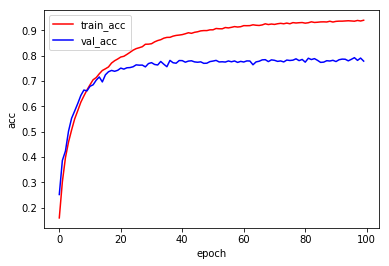

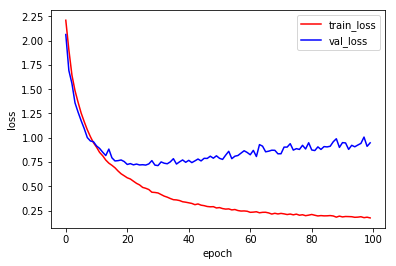

In [16]:
def plot_history(history):
    
    epochs = len(history['train_acc'],)
    
    xaxis = range(epochs)
    plt.figure()
    plt.plot(xaxis, history['train_acc'], 'r-', label='train_acc')
    plt.plot(xaxis, history['val_acc'], 'b-', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')


    plt.figure()
    plt.plot(xaxis, history['train_loss'], 'r-', label='train_loss')
    plt.plot(xaxis, history['val_loss'], 'b-', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

    
plot_history(history)


In [17]:
def test(model, classes, device, criterion, test_loader):
    outsize = len(classes)
    class_correct = list(0. for i in range(outsize))
    class_total = list(0. for i in range(outsize))
    runnning_loss = 0
    with torch.no_grad():
        for data in test_loader:
            imgs, labels = data
            n_batch = imgs.size(0)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            runnning_loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, 1)
            c = (pred == labels).squeeze()
            for i in range(n_batch):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(outsize):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        
    test_acc = int(sum(class_correct)/sum(class_total)*100)
    test_loss = runnning_loss / len(test_loader)
    print('acc  : {:2d}%'.format(test_acc))
    print('loss : {:.4f}'.format(test_loss) )


    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)
model = model.to(device)
test(model, classes, device, criterion, test_loader)

device: cuda
Accuracy of plane : 83 %
Accuracy of   car : 91 %
Accuracy of  bird : 69 %
Accuracy of   cat : 66 %
Accuracy of  deer : 75 %
Accuracy of   dog : 74 %
Accuracy of  frog : 85 %
Accuracy of horse : 84 %
Accuracy of  ship : 88 %
Accuracy of truck : 82 %
acc  : 80%
loss : 0.9337
